# 内容
- データ読み込み
- split
- x, y生成
- 学習
- 評価
- submit

In [1]:
import os
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection

import utils as ut

## 準備

In [2]:
DEBUG = True
ut.seed_everything(24)

In [3]:
tr_file = "../../input/ventilator-pressure-prediction/train.csv"
ts_file = "../../input/ventilator-pressure-prediction/test.csv"
tr_df = pd.read_csv(tr_file)
ts_df = pd.read_csv(ts_file)

In [4]:
# shuffled breath_id
tr_df["shuffled_breath_id"] = ut.make_shuffled_id(tr_df["breath_id"])

## 学習

In [5]:
def make_x(df):
    ft = ut.Feature()
    x = ft.transform(df)
    return x

def make_y(df):
    tg = ut.Target()
    y = tg.transform(df)
    return y

def get_model(n_feat, prefix=""):
    model_prms = {
        "scaling_prms": dict(n_scaler=n_feat),
        "dnn_prms": dict(n_feat=n_feat, n_channel=256, dropout=0.0, n_rc_layer=4), 
        "tr_prms": dict(
            criterion=ut.VentilatorLoss(),
            opt="adamw",
            opt_params=dict(lr=0.001, weight_decay=1e-6),
            sch_params=None, #{'max_lr': lr, 'pct_start':0.1, 'div_factor':5, 'final_div_factor': 10000}, # initial_lr = max_lr/div_factor, min_lr = initial_lr/final_div_factor
            epochs=20, 
            prefix=prefix,
            save_best=True,
            maximize_score=False,
        ), 
        "nn_prms": dict(
            n_neighbors=3, 
            n_jobs=4,
        ),
        "seq_len": 80,
        "use_seq_len": 40, 
        "train_batch_size": 256,
        "pred_batch_size": 1024,
    }
    model = ut.Model(**model_prms)
    return model

def run_fold(tr_df, vl_df, prefix=""):
    # x, y
    tr_x = make_x(tr_df)
    tr_y = make_y(tr_df)
    vl_x = make_x(vl_df)
    vl_y = make_y(vl_df)

    model = get_model(tr_x.shape[1], prefix)
    model.fit(tr_x, tr_y, vl_x, vl_y)

    #tr_pred = model.predict(tr_x)
    vl_pred = model.predict(vl_x)

    #tr_df = pd.concat([tr_df, tr_x, pd.DataFrame(tr_pred, index=tr_df.index, columns=["pred"])], axis=1)
    vl_df = pd.concat([vl_df, vl_x, pd.DataFrame(vl_pred, index=vl_df.index, columns=["pred"])], axis=1)
    return model, tr_df, vl_df

def run_cv(df, n_split, n_fold):
    kf = model_selection.GroupKFold(n_splits=n_split)

    oof_df = []
    for fold, (tr_idxs, vl_idxs) in enumerate(kf.split(X=np.arange(len(df)), groups=df["shuffled_breath_id"].values)):
        if n_fold <= fold:
            break
        print("fold", fold)
        prefix = f"fold{fold}_"

        tr_df = df.iloc[tr_idxs].copy()
        vl_df = df.iloc[vl_idxs].copy()
        #vl_df = df.iloc[tr_idxs].copy()
        tr_df["fold"] = fold
        vl_df["fold"] = fold

        model, tr_df, vl_df = run_fold(tr_df, vl_df, prefix)

        oof_df.append(vl_df)
        with open(f'{prefix}model.pickle', mode='wb') as fp:
            model.set_dev('cpu')
            pickle.dump(model, fp)

        #tr_df.to_csv(f"{prefix}tr_df.csv", index=False)
        #vl_df.to_csv(f"{prefix}vl_df.csv", index=False)
    oof_df = pd.concat(oof_df, axis=0)

    return oof_df

In [6]:
n_split = 2
n_fold = 1
oof_df = run_cv(tr_df, n_split, n_fold)
oof_df.to_csv("oof.csv")

fold 0


## 評価

In [7]:
ev = ut.Evaluation(oof_df)

In [8]:
score = ev.calc_scores()
print(score)

{0: {'mae': 0.7228385735165345}, 'av': {'mae': 0.7228385735165345}}


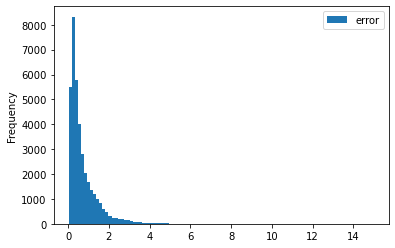

In [9]:
breath_mae = ev.calc_breath_mae()
breath_mae = breath_mae.sort_values("error", ascending=False)
breath_mae.plot.hist(bins=100)
plt.show()

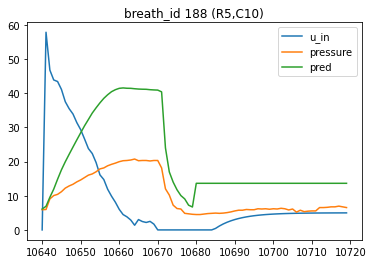

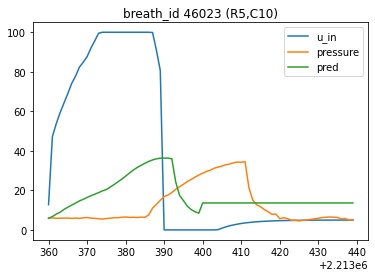

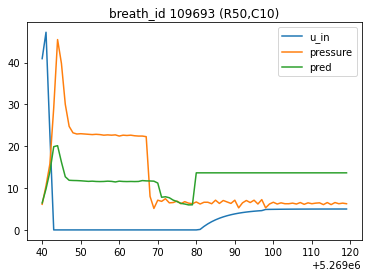

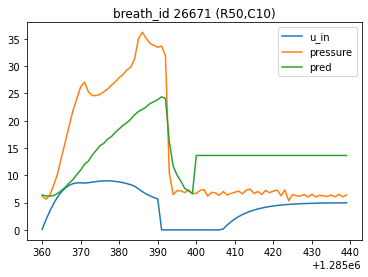

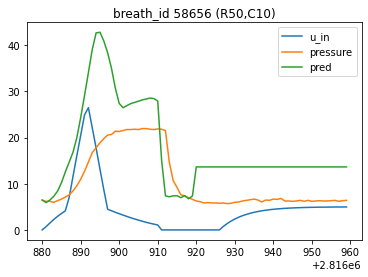

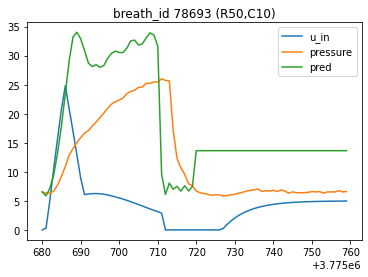

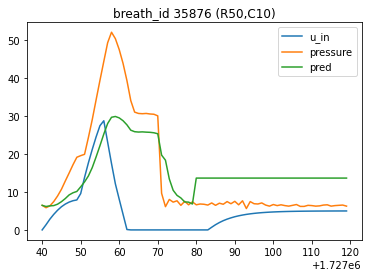

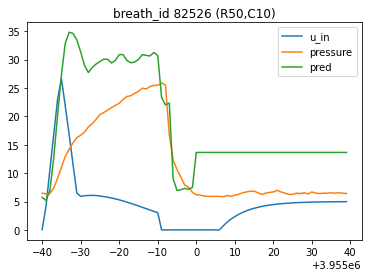

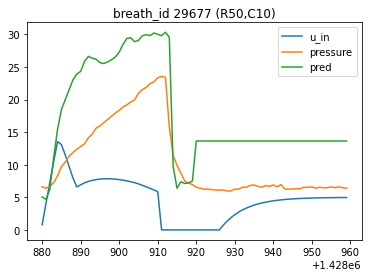

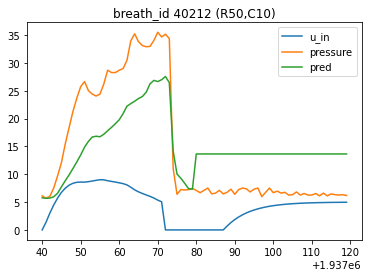

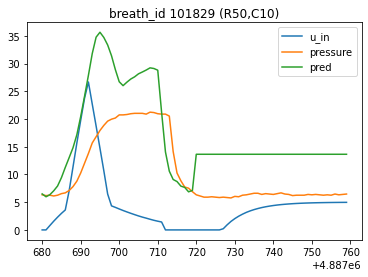

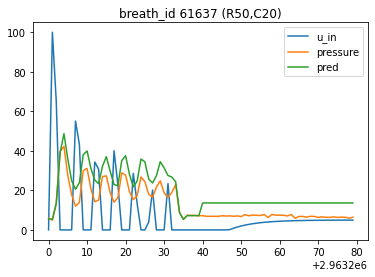

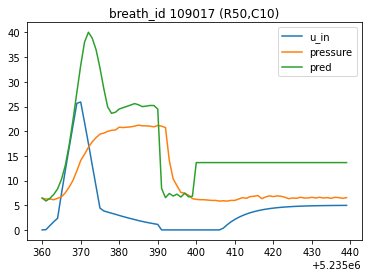

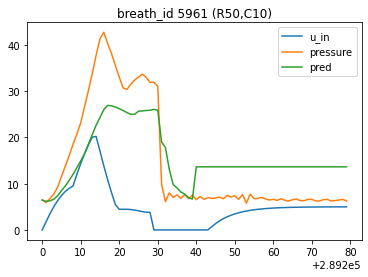

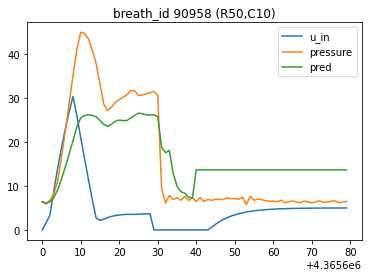

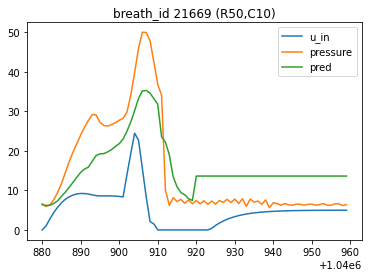

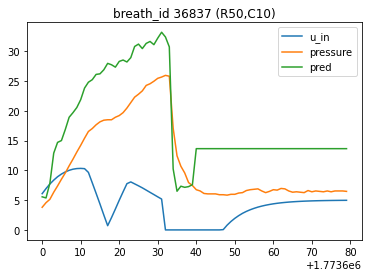

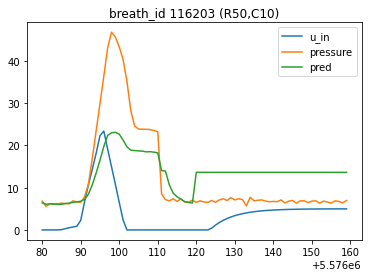

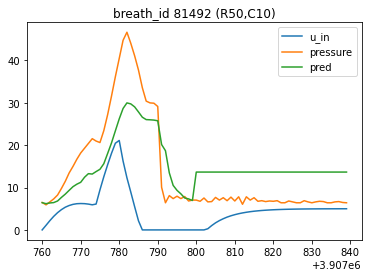

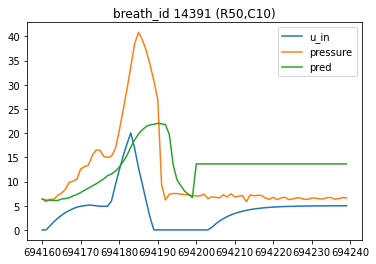

In [10]:
n_plot = 20
for i in range(n_plot):
    ev.plot_breath(breath_mae.index[i])

## 推論

In [11]:
def run_predict(model, df):
    x = make_x(df)
    pred = model.predict(x)
    return pred    

In [12]:
model = []
for fold in range(n_fold):
    with open(f"fold{fold}_model.pickle", 'rb') as p:
        mdl = pickle.load(p)
    model.append(mdl)

model = ut.EnsembleModel(model)

In [13]:
pred = run_predict(model, ts_df)
sub_df = ts_df[["id"]].copy()
sub_df["pressure"] = pred
sub_df.to_csv(f"submission_{os.path.basename(os.getcwd())}.csv", index=False)